# Modeling

In [1]:
import pandas as pd
from pandas import Series
import pandas.core.algorithms as algos
import numpy as np
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import traceback
import re
import string
import warnings
import collections
import shap
import xgboost
from xgboost import XGBClassifier
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, log_loss, auc, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
import datetime

from library.sb_utils import save_file

In [2]:
# import data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [3]:
display(X_train.shape)
display(X_train.info())

(639, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Day_of_week             639 non-null    int64  
 1   Depart                  639 non-null    float64
 2   Fourteenday_lag         639 non-null    float64
 3   Heat                    639 non-null    float64
 4   Month_Name_July         639 non-null    int64  
 5   Month_Name_June         639 non-null    int64  
 6   Month_Name_Oct          639 non-null    int64  
 7   PrecipTotal             639 non-null    float64
 8   ResultDir               639 non-null    float64
 9   Season_Summer           639 non-null    int64  
 10  Sevenday_lag            639 non-null    float64
 11  Species_CULEX PIPIENS   639 non-null    int64  
 12  Species_CULEX RESTUANS  639 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 65.0 KB


None

In [4]:
display(X_test.shape)
display(X_test.info())

(275, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Day_of_week             275 non-null    int64  
 1   Depart                  275 non-null    float64
 2   Fourteenday_lag         275 non-null    float64
 3   Heat                    275 non-null    float64
 4   Month_Name_July         275 non-null    int64  
 5   Month_Name_June         275 non-null    int64  
 6   Month_Name_Oct          275 non-null    int64  
 7   PrecipTotal             275 non-null    float64
 8   ResultDir               275 non-null    float64
 9   Season_Summer           275 non-null    int64  
 10  Sevenday_lag            275 non-null    float64
 11  Species_CULEX PIPIENS   275 non-null    int64  
 12  Species_CULEX RESTUANS  275 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 28.1 KB


None

In [5]:
y_train = y_train['WnvPresent']
display(y_train.shape)

(639,)

In [6]:
y_test = y_test['WnvPresent']
display(y_test.shape)

(275,)

### RandomForestClassifier

In [7]:
# Instantiate model with 1000 decision trees
rfc = RandomForestClassifier(n_estimators = 10, 
                            random_state = 42, 
                            max_depth=50, 
                            class_weight = 'balanced',
                            #class_weight=dict({1:48, 0:1}), 
                            verbose=2)

# Fit the model on training data
rfc.fit(X_train, y_train)
y_pred1 = rfc.predict(X_test)
print("Features",rfc.feature_importances_)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Features [0.04692885 0.07730766 0.20687078 0.04064711 0.04786621 0.04850296
 0.00404483 0.04415088 0.06364948 0.01711293 0.21211504 0.10882554
 0.08197773]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [8]:
# ROC Score
roc1 = roc_auc_score(y_test, y_pred1)
print('ROC Score: {}'.format(roc1))

ROC Score: 0.7548448586254368


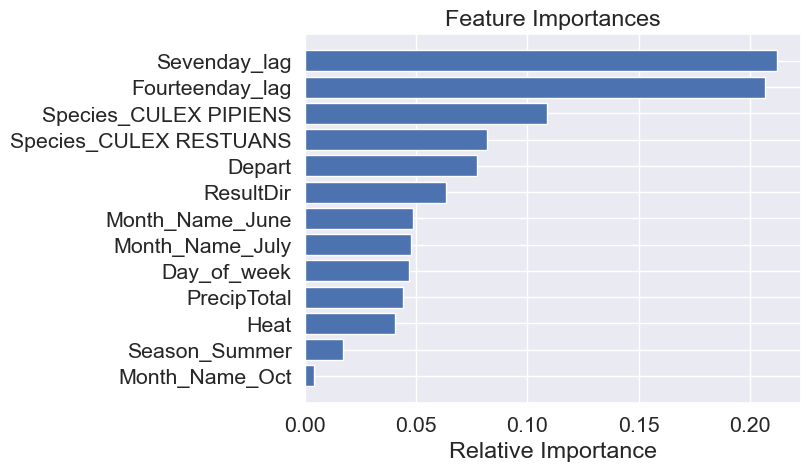

In [35]:
importances = rfc.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), 
         importances[indices], 
         align='center')
plt.yticks(range(len(indices)), 
           [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('../images/RFC_Feature_Importance.png', bbox_inches='tight')
plt.show()

[[ 98  44]
 [ 24 109]]


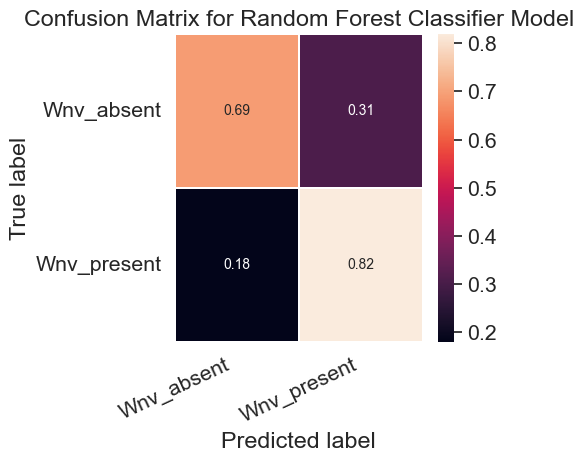

In [34]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, 
            annot=True, 
            annot_kws={'size':10},
            linewidths=0.2)
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.savefig('../images/RFC_Confusion_Matrix.png', bbox_inches='tight')
plt.show()

### XGBClassifier

In [11]:
# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, 
                    max_depth=30, 
                    max_delta_step=4, 
                    scale_pos_weight=49, 
                    random_state = 42, 
                    verbosity=2, 
                    n_jobs=-1, 
                    oob_score=True)

# Fit the model on training data
xgb.fit(X_train, y_train)
y_pred3 = xgb.predict(X_test)
roc3 = roc_auc_score(y_test, y_pred3)
roc3

[14:20:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "oob_score" } are not used.

[14:20:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:20:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=10
[14:20:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=11
[14:20:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned no

0.7173567722122207

[[ 66  76]
 [  4 129]]


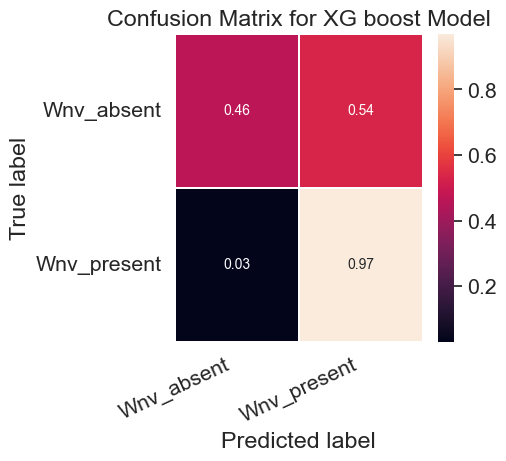

In [12]:
print(confusion_matrix(y_test, y_pred3))
matrix = confusion_matrix(y_test, y_pred3)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize = (4,4))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, 
            annot = True, 
            annot_kws = {'size':10},
            linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

In [13]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.94      0.46      0.62       142
           1       0.63      0.97      0.76       133

    accuracy                           0.71       275
   macro avg       0.79      0.72      0.69       275
weighted avg       0.79      0.71      0.69       275



0.7173567722122207


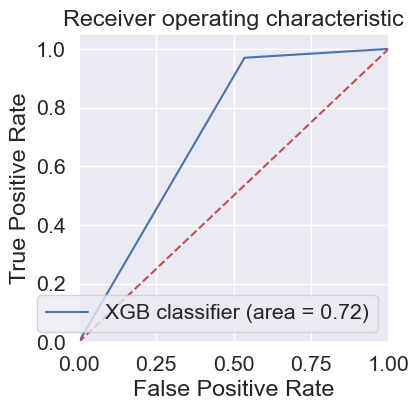

In [25]:
roc3 = roc_auc_score(y_test, y_pred3)
print(roc3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='XGB classifier (area = %0.2f)' % roc3 )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### GridSearchCV

In [15]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False):
                       #model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
                       
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [16]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

#model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state = 42, verbosity=2)
model = XGBClassifier(n_jobs=-1, 
                      random_state=42, 
                      verbosity=2)

In [17]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='roc_auc')

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=7
[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-

[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=9
[14:20:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 e

[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 e

[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=10
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=10
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=10
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=10
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 e

[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 e

[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 e

[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=11
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=11
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=11
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=11
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 e

[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 e

[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 e

[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 e

[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=7
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=7
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 e

[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 e

[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=10
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=10
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=10
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=10
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 e

[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=11
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=11
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=11
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=11
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=11
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=11
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=11
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[14:20:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 e

[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=9
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 e

[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 e

[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[14:20:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 e

[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=9
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 e

[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=11
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=11
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=11
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=11
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=11
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=11
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=11
[14:20:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 e

[CV] END eta=0.01, grow_policy=losswise, max_delta_step=8, max_depth=11, scale_pos_weight=49; total time=   0.0s
[CV] END eta=0.01, grow_policy=losswise, max_delta_step=8, max_depth=11, scale_pos_weight=50; total time=   0.0s
[CV] END eta=0.01, grow_policy=losswise, max_delta_step=8, max_depth=11, scale_pos_weight=50; total time=   0.0s
[CV] END eta=0.01, grow_policy=losswise, max_delta_step=8, max_depth=11, scale_pos_weight=50; total time=   0.0s
[CV] END eta=0.01, grow_policy=losswise, max_delta_step=8, max_depth=11, scale_pos_weight=50; total time=   0.0s
[CV] END eta=0.01, grow_policy=losswise, max_delta_step=8, max_depth=11, scale_pos_weight=50; total time=   0.0s
[CV] END eta=0.01, grow_policy=losswise, max_delta_step=8, max_depth=11, scale_pos_weight=51; total time=   0.0s
[CV] END eta=0.01, grow_policy=losswise, max_delta_step=8, max_depth=11, scale_pos_weight=51; total time=   0.0s
[CV] END eta=0.01, grow_policy=losswise, max_delta_step=8, max_depth=11, scale_pos_weight=51; to

[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=9
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=9
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=9
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=9
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 e

[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 e

[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=7
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 e

[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 68 e

[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 e

[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=9
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=9
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=9
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=9
[14:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 64 e

[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=9
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=10
[14:20:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 4

[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=11
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=11
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=11
[CV] END eta=0.05, grow_policy=depthwise, max_delta_step=4, max_depth=11, scale_pos_weight=49; total time=   0.2s
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost

[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=9
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=9
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=9
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 e

[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=7
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=9
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 e

[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=10
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=10
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=9
[14:20:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 9

[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 e

[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=8
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 82 e

[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=8
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 e

[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=9
[14:20:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 20 e

[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=9
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=9
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94

[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end,

[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=11
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=11
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=10
[14:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 e

[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 e

[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=8
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 70 e

[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=11
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=10
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=9
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=10
[14:20:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 8

[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=11
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=11
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=11
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=11
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=9
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=9
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=11
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=11
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60

[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=9
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=9
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=9
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 e

[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=10
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=10
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[14:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end,

[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=9
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=9
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=9
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=9
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 90 e

[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=10
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=10
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=10
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=11
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=11
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=11
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=11
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=10
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=10
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=11
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=10
[14:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=10
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 9

[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=11
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 44 e

[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 26 e

[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=9
[14:20:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 50 e

[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=9
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=9
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=9
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=9
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 68 e

[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=10
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=10
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=10
[CV] END eta=0.1, grow_policy=depthwise, max_delta_step=6, max_depth=10, scale_pos_weight=49; total time=   0.3s
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=7
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/

[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=10
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=10
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=10
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=9
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=10
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=10
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=9
[14:20:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88

[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=9
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=11
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=8
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=10
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 66

[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=11
[CV] END eta=0.1, grow_policy=depthwise, max_delta_step=6, max_depth=11, scale_pos_weight=49; total time=   0.3s
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=7
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/py

[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=11
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=11
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=9
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=10
[14:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 9

[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=10
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=10
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=11
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=11
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end,

[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=9
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=7
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=7
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 28 e

[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=9
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=9
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=9
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=9
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 70 e

[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=9
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=9
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=9
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=9
[14:20:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 50 e

[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=9
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=9
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 8

[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=10
[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=10
[14:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=10
[14:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=10
[14:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=9
[14:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[14:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=11
[14:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=11
[14:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=11
[14:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=11
[CV] END eta=0.1, grow_policy=depthwise, max_delta_step=8, max_depth=11, scale_pos_weight=51; total time=   0.2s
[14:20:29] INFO: /Users/runner/work/xgboost/xgboost


405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ramijauregui/opt/anaconda3/envs/virtual/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ramijauregui/opt/anaconda3/envs/virtual/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/ramijauregui/opt/anaconda3/envs/virtual/lib/python3.8/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users/ramijauregui/opt/anaconda3/envs/virtual/lib/python3.8/site-packages/

In [18]:
print(model.best_score_)
print(model.best_params_)

0.7773996489621489
{'eta': 0.05, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 11, 'scale_pos_weight': 51}


In [19]:
xgb = XGBClassifier(eta=0.05, 
                    max_delta_step=4, 
                    max_depth=11,
                    grow_policy='depthwise',
                    scoring_fit='roc_auc', 
                    scale_pos_weight=51, 
                    n_jobs=-1, 
                    random_state=42, 
                    verbosity=2)
xgb.fit(X_train, y_train)

[14:20:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scoring_fit" } are not used.

[14:20:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:20:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:20:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:20:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned no

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=4,
              max_depth=11, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...)

Test 0.7171185004765435


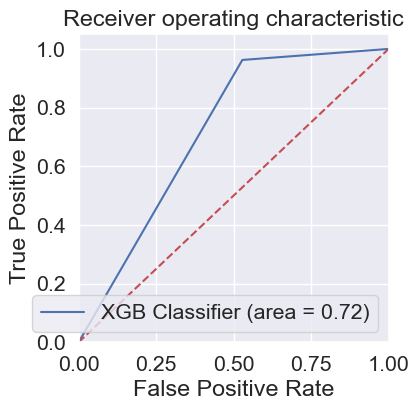

In [33]:
y_pred = xgb.predict(X_test)

roc = roc_auc_score(y_test, y_pred)

print("Test",roc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('../images/XGB_Log_ROC.png', bbox_inches='tight')
plt.show()

[[ 67  75]
 [  5 128]]


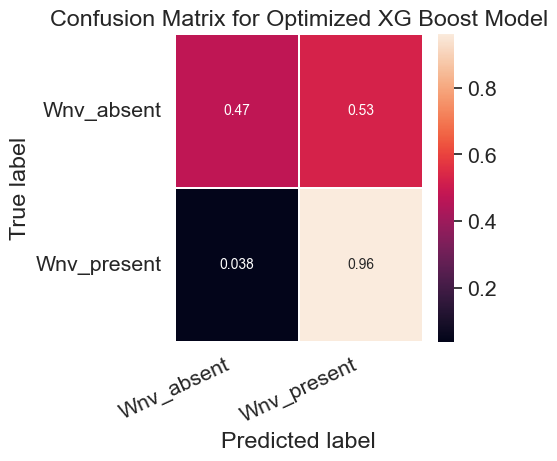

In [36]:
y_pred=pred
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, 
            annot=True, 
            annot_kws={'size':10},
            linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Optimized XG Boost Model')
plt.savefig('../images/XGB_Confusion_Matrix.png', bbox_inches='tight')
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.47      0.63       142
           1       0.63      0.96      0.76       133

    accuracy                           0.71       275
   macro avg       0.78      0.72      0.69       275
weighted avg       0.79      0.71      0.69       275



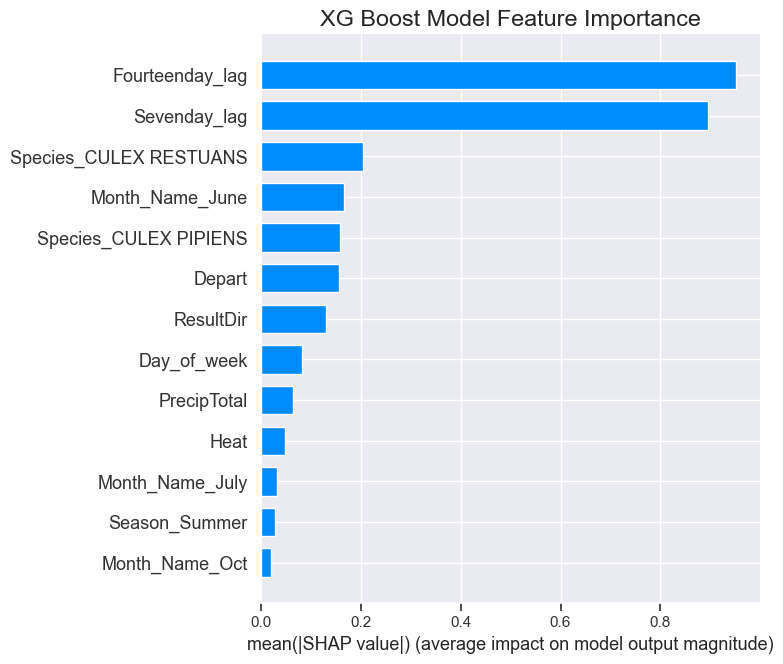

In [38]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title('XG Boost Model Feature Importance')
plt.savefig('../images/XGB_Feature_Importance.png', bbox_inches='tight')
plt.show()

In [24]:
best_model = xgb

In [107]:
# save the model
modelpath = '../models'
save_file(best_model, 'west_nile_virus_prediction_model.pkl', modelpath)

Writing file.  "../models/west_nile_virus_prediction_model.pkl"
